# agenda
1. wikipedia training data
1. plots
1. concept categorization (data, how to define on topic models?)
1. spearmint
1. FutureSoc

# Data

* Latest Wikipedia corpus
* Extracted plain text
* Only used first 1000 words per document
* 87,380,300 sentences
* 1,813,672,600 words, 9,996,018 unique words

## topic model training
* Using mallet
* 256 topics, 400 iterations, 13 hours

## word2vec training
* skip-gram model in gensim
* 3.5 hours
* remove words occurring less than 50 times --> 386,046 words unique words (98 % of original corpus)


# Setup

In [1]:
%matplotlib notebook

import itertools
from functools import partial
import numpy as np
import gensim, logging
import pandas as pnd
from sklearn.cluster import *
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, RandomizedPCA
import matplotlib.pyplot as plt

In [2]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [3]:
from IPython.core.display import HTML
HTML("""
<style>
div.text_cell_render p, div.text_cell_render ul, table.dataframe {
font-size:1.3em;
line-height:1.1em;
}
</style>
""")

# Preprocessing

## Topic model

In [4]:
# Prepare data in long form

df_topics = pnd.read_csv("../code/resources/topics.txt", header=None)
df_topics["topic"] =  df_topics.index
df_topics["topic_name"] = df_topics[0]

df = pnd.melt(df_topics, id_vars=["topic", "topic_name"], var_name="position", value_name="word")
df = df[["word", "topic", "topic_name", "position"]]
df = df.sort_values(by=["topic", "position"]).reset_index(drop=True)
df[df.topic == 0]

,word,topic,topic_name,position
0,english,0,english,0
1,england,0,english,1
2,king,0,english,2
3,one,0,english,3
4,scotland,0,english,4
5,britain,0,english,5
6,british,0,english,6
7,london,0,english,7
8,john,0,english,8
9,name,0,english,9


## Word embeddings

In [5]:
WORD2VEC_VECTOR_FILE = "/home/knub/Repositories/master-thesis/data/GoogleNews-vectors-negative300.bin"
GLOVE_VECTOR_FILE = "/home/knub/Repositories/master-thesis/data/glove.6B.50d.txt"
CBOW_VECTOR_FILE = "/home/knub/Repositories/master-thesis/data/embedding.model.cbow"
SKIP_GRAM_VECTOR_FILE = "/home/knub/Repositories/master-thesis/data/embedding.model.skip-gram"

vectors_glove = gensim.models.Word2Vec.load_word2vec_format(GLOVE_VECTOR_FILE, binary=False)
vectors_skip = gensim.models.Word2Vec.load_word2vec_format(SKIP_GRAM_VECTOR_FILE, binary=True)
vectors_cbow = gensim.models.Word2Vec.load_word2vec_format(CBOW_VECTOR_FILE, binary=True)
vectors_default = vectors_skip
#vectors_word2vec = gensim.models.Word2Vec.load_word2vec_format(WORD2VEC_VECTOR_FILE, binary=True)

In [7]:
def get_data_frame_from_word_vectors(df_param, vectors):
    df_param = df_param[df_param["word"].apply(lambda word: word in vectors)]    
    df_param["embeddings"] = df_param["word"].apply(lambda word: vectors[word])
    return df_param

df = get_data_frame_from_word_vectors(df.copy(), vectors_default)
df[df.topic == 0]

,word,topic,topic_name,position,embeddings
0,english,0,english,0,"[0.0422775, 0.0406305, -0.0266737, 0.141661, 0..."
1,england,0,english,1,"[-0.0624141, 0.0224915, 0.0535197, -0.259721, ..."
2,king,0,english,2,"[-0.196065, -0.414018, 0.0676933, -0.137647, -..."
3,one,0,english,3,"[-0.168926, 0.0148157, 0.0755794, 0.142491, 0...."
4,scotland,0,english,4,"[-0.0881893, 0.141681, 0.0661018, -0.423509, 0..."
5,britain,0,english,5,"[-0.0441866, 0.0964522, 0.191539, -0.161046, 0..."
6,british,0,english,6,"[-0.212099, 0.00809204, -0.0368557, -0.0807824..."
7,london,0,english,7,"[-0.0839832, 0.0908299, -0.094307, -0.184286, ..."
8,john,0,english,8,"[-0.000240857, -0.032411, 0.152528, 0.0660215,..."
9,name,0,english,9,"[0.387686, 0.2614, 0.0852883, 0.294565, 0.0900..."


In [8]:
# financial, muslim, teams in sport, atom physics, math
nice_topics = [5, 117, 158, 164, 171]
nice_topics = [0, 7, 236]

df_part = df[df.topic.apply(lambda topic: topic in nice_topics)].copy()
# Show topics of interest
df_tmp = pnd.DataFrame(df_part.groupby("topic")["word"].apply(lambda l: l.tolist()).tolist())
df_tmp.index = nice_topics
df_tmp

,0,1,2,3,4,5,6,7,8,9
0,english,england,king,one,scotland,britain,british,london,john,name
7,dutch,netherlands,bin,holland,attacks,amsterdam,september,laden,inquisition,al-qaeda
236,greek,greece,ice,hockey,plague,ancient,athens,island,aegean,apollo


## Dimensionality reduction

In [9]:
def pca(embeddings, n=2):
    pca = RandomizedPCA(n_components=n)
    return pca.fit_transform(embeddings)

def tsne(embeddings):
    tsne = TSNE(n_components=2)
    return tsne.fit_transform(embeddings)

def tsne_with_init_pca(embeddings):
    tsne = TSNE(n_components=2, init="pca")
    return tsne.fit_transform(embeddings)

# Topic model in word embedding space

## Plot preparation

In [10]:
def plot_topics_in_embedding_space(reduction_method, df_param):
    embeddings = np.array(df_param["embeddings"].tolist())
    X = reduction_method(embeddings)
    df_tmp = df_param.copy()
    df_tmp["x"] = X[:,0]
    df_tmp["y"] = X[:,1]
    df_tmp = df_tmp[df_tmp.topic.apply(lambda topic: topic in nice_topics)]
    colors = {0: "red", 7: "blue", 236: "green", 164: "yellow", 171: "black"}
    plt.figure(figsize=(12, 8))
    plt.scatter(df_tmp.x, df_tmp.y, c=df_tmp.topic.apply(lambda topic: colors[topic]), s=80)
    
    ylim = plt.gca().get_ylim()
    step = (ylim[1] - ylim[0]) / 100
    
    for index, row in df_tmp.iterrows():
        plt.text(row.x, row.y - step, row.word, horizontalalignment='center', verticalalignment='top')

## PCA

In [11]:
#plot_topics_in_embedding_space(pca, df)

<IPython.core.display.Javascript object>


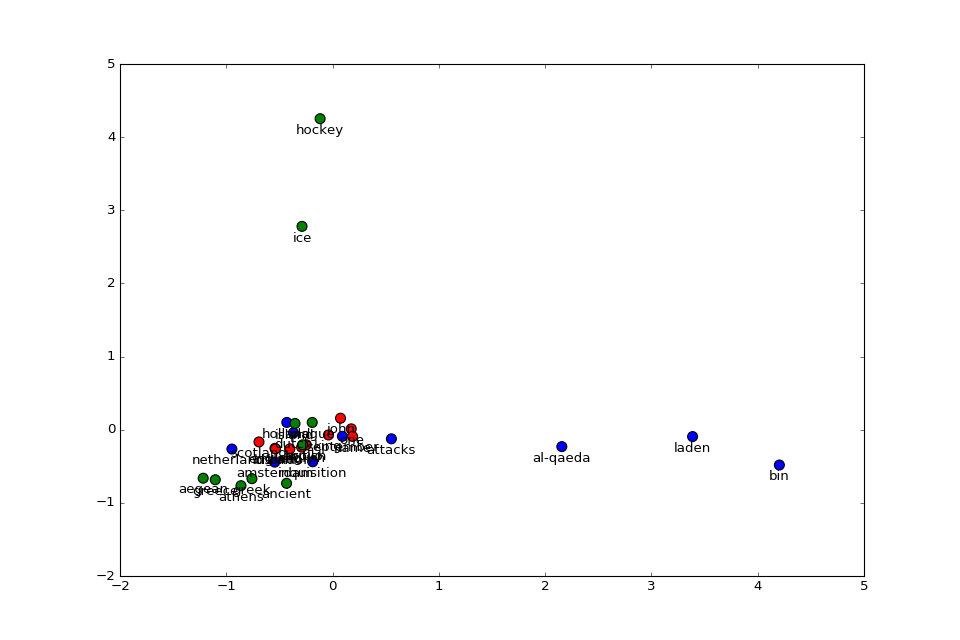

In [12]:
plot_topics_in_embedding_space(pca, df_part) # third dimensions

## t-SNE

In [ ]:
#plot_topics_in_embedding_space(tsne, df)

## t-SNE with PCA initialization

<IPython.core.display.Javascript object>


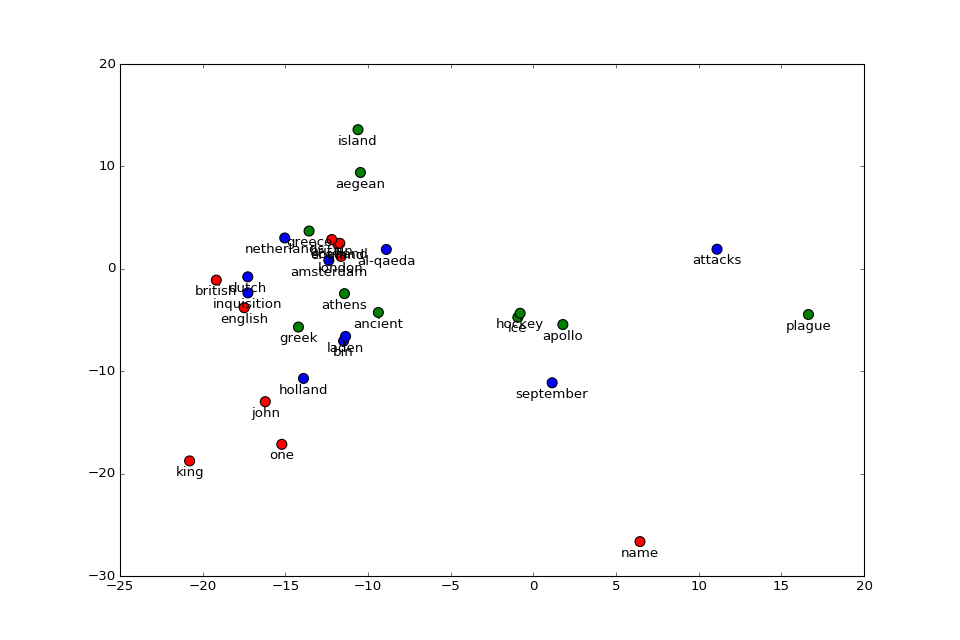

In [13]:
plot_topics_in_embedding_space(tsne_with_init_pca, df)

## Findings

Topics from the topic model do not seem to be in similar positions in the vector space, in general.

* **Specifity**: The more specific a word is, the closer it is to similar words in the word embedding space. See the "muslim", "islam", "mohammad" cluster.
* **Ambiguity**: Ambiguous words are a special problem, for example "current" is far away from the other physic terms because it has too many meanings. In fact, it is very close to the word "new".
* **Context-based similarity**: Topic models can assign different similarities between words based on the context. They are good at finding similar words in a context, which might not be immediately obvious. Example: "distribution" is not very similar to "function", however in the company of "mean", "probability", "data", "random" it is. See also "Exploring the Space of Topic Coherence Measures" by Röder et al.

# Word embedding similarity of topics 

## Avg. pairwise similarity

In [23]:
def average_pairwise_similarity(words, vectors):
    word_pairs = itertools.permutations(words, 2)
    similarities = [vectors.similarity(word1, word2) for word1, word2 in word_pairs if word1 < word2]
    return np.mean(similarities)

def average_top_similarity(words, vectors):
    word_pairs = itertools.permutations(words, 2)
    similarities = [(word1, vectors.similarity(word1, word2)) for word1, word2 in word_pairs]
    max_similarities = [max([s for w, s in l]) for _, l in itertools.groupby(similarities, lambda s: s[0])]
    return np.mean(max_similarities)

In [24]:
topic_lengths = list(range(2, 11))
def calculate_similarities_for_topic(df_topic, sim_function, vectors):
    words_in_topic = df_topic["word"].tolist()
    
    average_similarities = [sim_function(words_in_topic[:topic_length], vectors)
                            for topic_length in topic_lengths]
    
    return pnd.Series(average_similarities)

def calculate_similarity_matrix(sim_function, vectors):
    def partial_function(df_topic):
        return calculate_similarities_for_topic(df_topic, sim_function, vectors)

    df_similarities = df.groupby("topic").apply(partial_function)
    df_similarities.columns = ["%s-words" % i for i in topic_lengths]
    return df_similarities

In [25]:
df_similarities = calculate_similarity_matrix(average_pairwise_similarity, vectors_default)
df_similarities.mean()

2-words     0.299363
3-words     0.260626
4-words     0.248480
5-words     0.235489
6-words     0.220696
7-words     0.214236
8-words     0.206407
9-words     0.198030
10-words    0.192162
dtype: float64

<IPython.core.display.Javascript object>


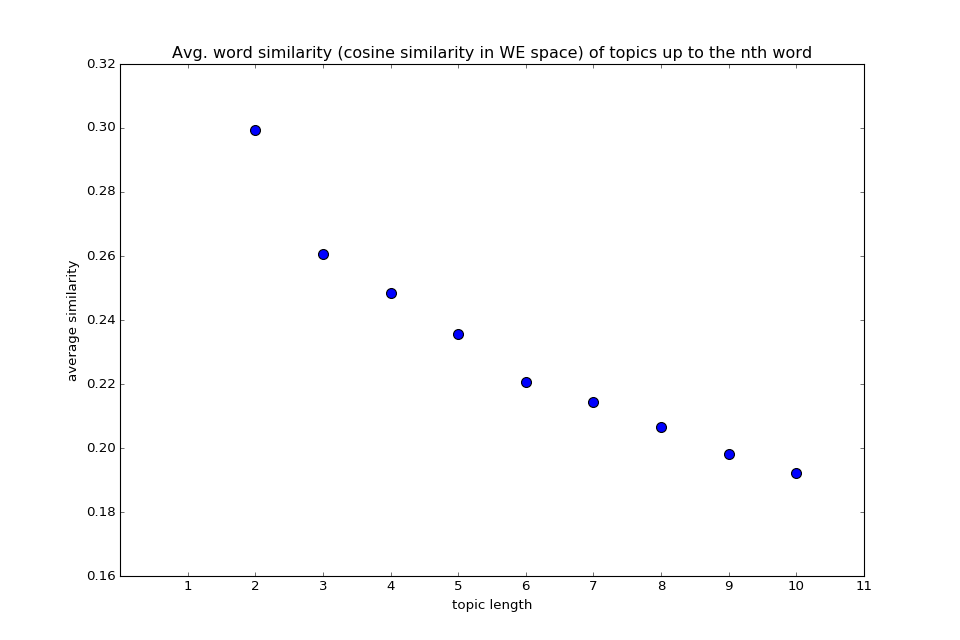

In [26]:
means = df_similarities.mean().tolist()
plt.figure(figsize=(12, 8))
plt.scatter(topic_lengths, means, s=80)
plt.title("Avg. word similarity (cosine similarity in WE space) of topics up to the nth word")
plt.xlim(0, 11)
plt.xticks(list(range(1, 12)))
#plt.ylim((0, 0.35))
plt.xlabel("topic length")
plt.ylabel("average similarity")

## Highest-similar topics

For comparison, here are a few standard similarities:

**king-prince**: {{vectors_default.similarity("king", "prince")}}
**king-queen**: {{vectors_default.similarity("king", "queen")}}
**topic-topics**: {{vectors_default.similarity("topic", "topics")}}
**buy-purchase**: {{vectors_default.similarity("buy", "purchase")}}

In [27]:
def show_highest_similar_topics(topic_length, nr_topics=3):
    column = "%s-words" % topic_length
    df_top = df_similarities.sort_values(by=column, ascending=False)[:nr_topics]
    return df_top.join(df_topics)[[column] + list(range(topic_length))]

In [28]:
show_highest_similar_topics(3)

,3-words,0,1,2
topic,,,,
239,0.779558,dna,proteins,protein
159,0.756716,cell,cells,membrane
164,0.726419,electrons,particles,electron


In [29]:
show_highest_similar_topics(6)

,6-words,0,1,2,3,4,5
topic,,,,,,,
239,0.685424,dna,proteins,protein,rna,cell,gene
190,0.474444,music,band,album,rock,song,songs
13,0.458192,navy,aircraft,naval,air,ships,ship


In [30]:
show_highest_similar_topics(10)

,10-words,0,1,2,3,4,5,6,7,8,9
topic,,,,,,,,,,,
239,0.600600,dna,proteins,protein,rna,cell,gene,genes,cells,sequence,amino
218,0.429596,computer,systems,system,technology,ibm,control,computers,used,device,devices
14,0.426687,fiction,science,story,novel,stories,published,book,fantasy,novels,world


## Findings

* In general, similarity is not very high after the first few words, when comparing against usual similarities
* Again, topics with highly specific words have highest WE similarity

# Concept categorization in WE

In [31]:
def get_word(word):
    try:
        return vectors_default[word]
    except:
        return vectors_default["this"]

df_concept = pnd.read_csv(
    "/home/knub/Repositories/master-thesis/data/concept-categorization/battig_concept-categorization.tsv",
    sep="\t",
    header=None)
df_concept.columns = ["word", "concept"]
df_concept["embeddings"] = df_concept["word"].apply(lambda word: get_word(word))
df_concept.head(2)

,word,concept,embeddings
0,dog,land-mammals,"[0.204732, -0.128094, -0.092474, -0.054532, 0...."
1,elephant,land-mammals,"[-0.0205331, -0.184742, -0.217134, -0.0277152,..."


In [32]:
X = np.array(df_concept["embeddings"].tolist())
X.shape

(82, 200)

In [35]:
# http://stats.stackexchange.com/questions/95731/how-to-calculate-purity
def single_cluster_purity(df_tmp):
    return df_tmp["concept"].value_counts().max()

def calculate_purity(df_with_clusters):
    purity = float(sum([single_cluster_purity(df_tmp)
                        for _, df_tmp
                        in df_with_clusters.groupby("cluster_id")])) / len(df_with_clusters)
    return purity

from sklearn import metrics

def evaluate_clustering_algorithm(clustering):
    # sim or not sim? PCA or not PCA?
    X_sim = metrics.pairwise.pairwise_distances(X, metric="cosine")
    clusters = clustering.fit_predict(X_sim)
    df_concept["cluster_id"] = clusters
    return calculate_purity(df_concept)

In [36]:
for clustering in [KMeans(n_clusters=10, init="k-means++", n_jobs=1),
                   KMeans(n_clusters=10, init="random", n_jobs=1),
                   AgglomerativeClustering(n_clusters=10, linkage="ward"),
                   AgglomerativeClustering(n_clusters=10, linkage="complete"),
                   AgglomerativeClustering(n_clusters=10, linkage="average"),
                   DBSCAN(eps=0.5, min_samples=4),
                   DBSCAN(eps=0.5, min_samples=5),
                   DBSCAN(eps=0.5, min_samples=7),
                   DBSCAN(eps=0.3, min_samples=5),
                   DBSCAN(eps=0.9, min_samples=5),
                   AffinityPropagation(damping=0.5),
                   AffinityPropagation(damping=0.6),
                   AffinityPropagation(damping=0.7),
                   AffinityPropagation(damping=0.8),
                   AffinityPropagation(damping=0.9),
                   SpectralClustering(n_clusters=10)]:
    print clustering.__class__.__name__
    print evaluate_clustering_algorithm(clustering)

KMeans
0.719512195122
KMeans
0.707317073171
AgglomerativeClustering
0.780487804878
AgglomerativeClustering
0.719512195122
AgglomerativeClustering
0.707317073171
DBSCAN
0.256097560976
DBSCAN
0.19512195122
DBSCAN
0.121951219512
DBSCAN
0.121951219512
DBSCAN
0.353658536585
AffinityPropagation
0.829268292683
AffinityPropagation
0.829268292683
AffinityPropagation
0.829268292683
AffinityPropagation
0.829268292683
AffinityPropagation
0.829268292683
SpectralClustering
0.670731707317
